# Unsupervised Anomaly Detection on fastMRI


## Data Upload


In [ ]:
# Download the data
#!wget https://syncandshare.lrz.de/dl/fiH6r4B6WyzAaxZXTEAYCE/data.zip
# Extract the data
#!unzip -q ./data.zip

## Imports


In [1]:
from torch.utils.data import DataLoader
from data_loader import BrainMRI, MVTecAT, Repeat, collate_function
from model import CutPasteNet
import matplotlib.pyplot as plt
import pytorch_lightning as pl


import yaml

import warnings

warnings.filterwarnings("ignore")


with open("./configs/model.yaml", "r") as f:
    config = yaml.safe_load(f)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Example Data Upload and Visualization


Using 581 IXI images and 130 fastMRI images. Total 711 images for training.


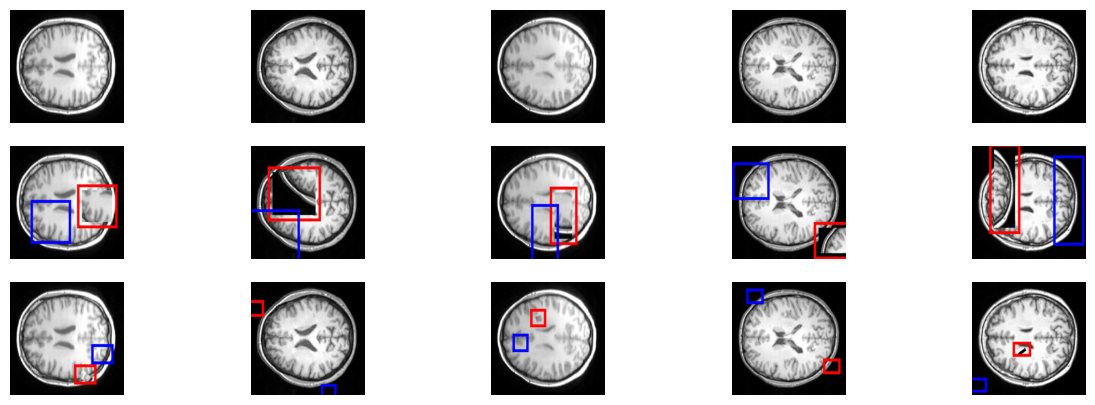

loading images
loaded 209 images


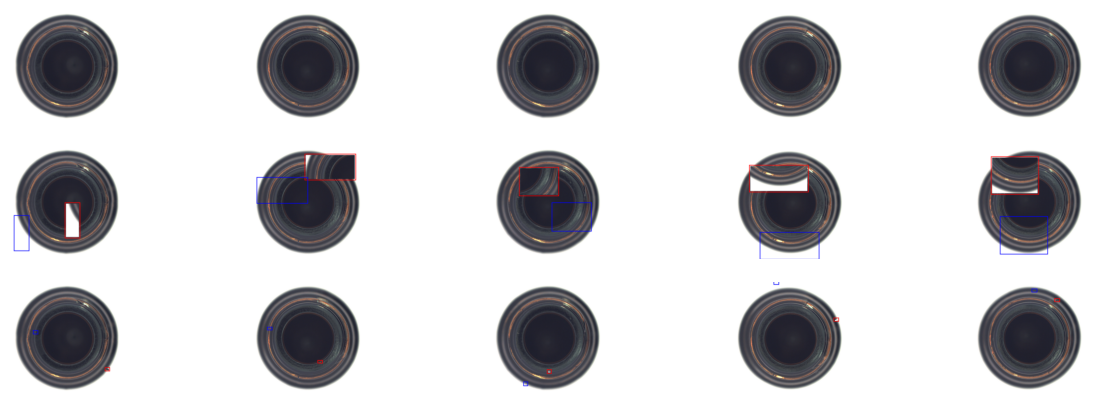

In [4]:
train_data_loader = DataLoader(
    BrainMRI(
        split_dir=config["split_dir"],
        size=config["target_size"],
        mode="train",
        cutpaste_type=config["cutpaste_type"],
        data_display_mode=True,
    ),
    batch_size=config["batch_size"],
    shuffle=True,
    collate_fn=collate_function,
)

batch = next(iter(train_data_loader))
fig, ax = plt.subplots(3, 5, figsize=(15, 5))
for i in range(5):
    ax[0][i].imshow(batch[0][i].T)
    ax[0][i].axis("off")
    ax[1][i].imshow(batch[1][i].T)
    ax[1][i].axis("off")
    ax[2][i].imshow(batch[2][i].T)
    ax[2][i].axis("off")
plt.show()

mvtecat_train_dataloader = DataLoader(
    MVTecAT(
        root_dir="dataMVT",
        defect_name="bottle",
        size=config["target_size"],
        mode="train",
        cutpaste_type=config["cutpaste_type"],
        data_display_mode=True,
    ),
    batch_size=config["batch_size"],
    shuffle=True,
    collate_fn=collate_function,
)

batch = next(iter(mvtecat_train_dataloader))
fig, ax = plt.subplots(3, 5, figsize=(15, 5))
for i in range(5):
    ax[0][i].imshow(batch[0][i].T)
    ax[0][i].axis("off")
    ax[1][i].imshow(batch[1][i].T)
    ax[1][i].axis("off")
    ax[2][i].imshow(batch[2][i].T)
    ax[2][i].axis("off")
plt.show()

## Model Training

### Data Upload

In [2]:
brainMRI_train_data_loader = DataLoader(
    BrainMRI(
        split_dir=config["split_dir"],
        size=config["target_size"],
        mode="train",
        cutpaste_type=config["cutpaste_type"],
    ),
    batch_size=config["batch_size"],
    drop_last=True,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_function,
)

mvtecat_train_dataloader = DataLoader(
    MVTecAT(
        root_dir="dataMVT",
        defect_name="bottle",
        size=config["target_size"],
        mode="train",
        cutpaste_type=config["cutpaste_type"],
    ),
    batch_size=config["batch_size"],
    drop_last=True,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_function,
)

Using 581 IXI images and 130 fastMRI images. Total 711 images for training.
Total 209 images.


## Prepare model

In [3]:
model = CutPasteNet(
    config,
    head_layer_count=2,
    num_classes=3 if config["cutpaste_type"] == "3way" else 2,
)

trainer = pl.Trainer(
    log_every_n_steps=4,
    max_epochs=config["num_epochs"],
    logger=[
        pl.loggers.CSVLogger(save_dir="./"),
        pl.loggers.TensorBoardLogger(save_dir="./"),
    ],
)

print("-----------------------------------------------")

trainer.fit(model, train_dataloaders=mvtecat_train_dataloader)

Selected device: mps


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | _RestNet18       | 11.8 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.080    Total estimated model params size (MB)


2
2
-----------------------------------------------
Epoch 58:   0%|          | 0/2 [00:00<?, ?it/s, v_num=0_31, train_loss=0.242, train_acc=0.911]        

## Evaluate Model